### <font color=blue>Luisa Sanchez Avivar</font>
###  Deteccion de Artefactos Impulsivos
#### Percepcion Computacional
---

/home/luisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/luisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


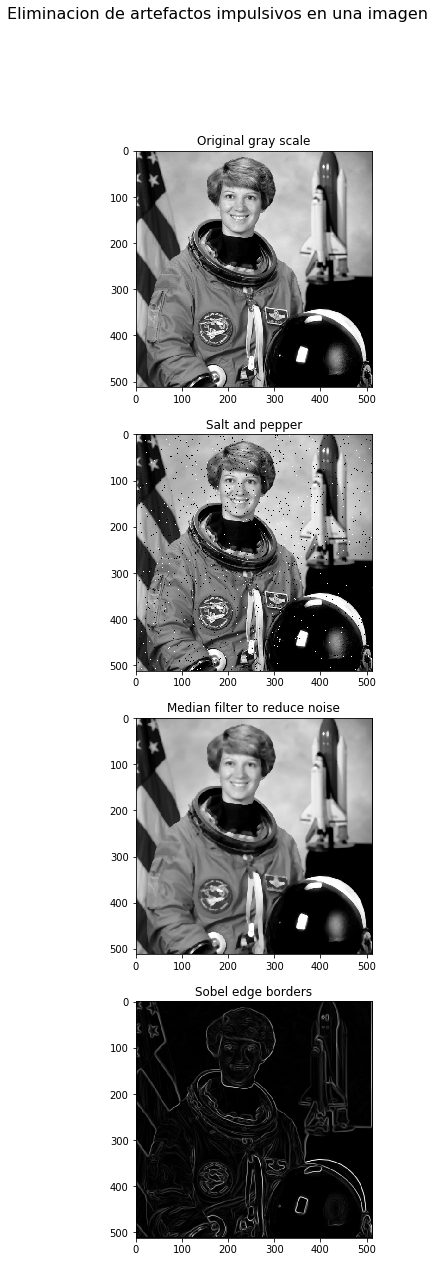

In [6]:
import numpy as np
import skimage
import math
import matplotlib.pyplot as plt
from skimage import feature
#import scipy.signal
%matplotlib inline 

########################################
#       Generacion de Ruido            #
########################################
'''
1. Recorremos la imagen generando n posiciones aleatorias en propocion a la cantidad de ruido deseada
2. Reemplazamos cada una de esas posiciones para:
    - Añadir el ruido blanco Salt 
    - Añadir ruido negro Pepper 
'''
#Añade ruido sal y pimienta a una imagen
def add_noise_sp(image):
    copy = image
    WHITE, BLACK = (1,0)
    salt_pepper = 0.2
    amount = 10
    num_salt = np.ceil(amount * copy[0].size * salt_pepper)
    num_pepper = np.ceil(amount * copy[0].size * (1.0 - salt_pepper))
    # Añadimos ruido blanco: Salt
    xy = [np.random.randint(0, i - 1, int(num_salt))for i in image.shape]
    copy[xy] = WHITE

    # Añadimos ruido negro: Pepper
    xy = [np.random.randint(0, i - 1, int(num_pepper))for i in image.shape]
    copy[xy] = BLACK
    
    return copy

########################################
#       Eliminacion de Ruido           #
########################################
'''
1. Se recorre la matriz y creamos una lista que contendra los puntos mas proximos
2. Si el punto se encuentra fuera de los indices: guarda 0
    Si no, agregamos el vecino correspondiente
    Cuando tenemos la lista, se ordena ascendentemente y obtenemos la mediana (y ese sera
    el pixel que se usara en la imagen que devolvemos)
'''

#Reduce el ruido existente en una imagen mediante el filtro de la Mediana
def median_filter(image, window):
    height, width = image.shape
    neighbour_values = []
    edgexy = window // 2
    copy = []
    copy = np.zeros((height,width))
    for i in range(height):
        for j in range(width):

            for z in range(window):    
                if ((i + z - edgexy < 0) or (i + z - edgexy > height - 1)):
                    #Height: Fuera de indices
                    for c in range(window):
                        neighbour_values.append(0)
                else:
                    #Width: Fuera de indices
                    if ((j + z - edgexy < 0) or (j + edgexy > width - 1)):
                        neighbour_values.append(0)
                    else:
                        for k in range(window):
                            px_x, px_y = (i + z - edgexy, j + k - edgexy)
                            neighbour_values.append(image[px_x][px_y])

            neighbour_values.sort()
            copy[i][j] = neighbour_values[len(neighbour_values) // 2]
            neighbour_values = [] 
            
    return copy

########################################
#       Detencion de bordes            #
########################################
'''
1. Definimos las matrices que utiliza el algoritmo para detectar los 
   bordes horizontales y verticales por separado
2. Recorremos la matriz y calculamos el gradiente para cada orientacion (hor/ver) aplicando
   la mascara correspondiente 
3. Añado a la nueva imagen la magnitud combinada de ambos gradientes
'''

#Aplica el filtro de Sobel para detectar los bordes en una imagen 2d
def sobel_boders_filter(image):
    height, width = image.shape
    mask_s1 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float)
    mask_s2 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = np.float)
    output_img = np.zeros((height, width))
    
    for i in range(1, (height - 1)):
        for j in range(1, (width - 1)):
            
            #scipy.signal.convolve2d(img, kh, mode='same', boundary = 'symm', fillvalue=0)
            Gx = (mask_s1[0, 0] * image[i-1, j-1]) + (mask_s1[0,1] * image[i-1, j]) + \
                            (mask_s1[0,2] * image[i-1, j+1]) + (mask_s1[1,0] * image[i, j-1]) + \
                            (mask_s1[1,1] * image[i, j]) + (mask_s1[1,2] * image[i, j+1]) + \
                            (mask_s1[2,0] * image[i+1, j-1]) + (mask_s1[2,1] * image[i+1, j]) + \
                            (mask_s1[2,2] * image[i+1, j+1])

            #scipy.signal.convolve2d(img, kh, mode='same', boundary = 'symm', fillvalue=0)
            Gy = (mask_s2[0, 0] * image[i - 1, j - 1]) + (mask_s2[0,1] * image[i-1, j]) + \
                           (mask_s2[0,2] * image[i-1, j+1]) + (mask_s2[1,0] * image[i, j-1]) + \
                           (mask_s2[1,1] * image[i, j]) + (mask_s2[1,2] * image[i, j+1]) + \
                           (mask_s2[2,0] * image[i+1, j - 1]) + (mask_s2[2,1] * image[i+1, j]) + \
                           (mask_s2[2,2] * image[i+1, j + 1])
            
            mag = np.sqrt((pow(Gx, 2.0)) + (pow(Gy, 2.0)))
            output_img[i-1, j-1] = mag
            
    return output_img


            
########################################
#                 Main                 #
########################################    
astro_color_img = skimage.data.astronaut()
astro_bw_img = skimage.color.rgb2gray(astro_color_img)
#new_image = np.stack((astro_bw_img,)*3, axis=-1)
#skimage.io.imshow(astro_bw_img)

# Generacion de Ruido
salt_and_pepper_img = add_noise_sp(astro_bw_img)
#skimage.io.imshow(salt_pepper_noise_imgs2)

# Eliminar Ruido
median_img = median_filter(salt_and_pepper_img, 5)
#skimage.io.imshow(no_noise)

# Detencion de bordes 
border_img =sobel_boders_filter(median_img)
#skimage.io.imshow(border_img)
#edges2 = feature.canny(median_img, sigma=3)
#skimage.io.imshow(edges2)

# Mostramos las imagenes
fig, ax = plt.subplots(4, 1, figsize =(40, 20))
fig.suptitle('Eliminacion de artefactos impulsivos en una imagen', fontsize=16)
ax[0].set_title("Original gray scale")
ax[0].imshow(skimage.color.rgb2gray(astro_color_img), cmap = plt.cm.gray)
ax[1].set_title("Salt and pepper")
ax[1].imshow(salt_and_pepper_img, cmap = plt.cm.gray)
ax[2].set_title("Median filter to reduce noise")
ax[2].imshow(median_img, cmap = plt.cm.gray)
ax[3].set_title("Sobel edge borders")
ax[3].imshow(border_img, cmap = plt.cm.gray)
plt.show()